In [1]:
import mediator as md
import optimizer as op
import generator as gn
import torch
import random

def generate_random_graph(N: int, sparsity: float, device='cpu'):
    """
    ランダムな対称スパース隣接行列 A ∈ {0,1}^{N×N} を生成。
    
    Parameters:
        N: ノード数
        sparsity: スパース率（0.0 = 完全結合, 1.0 = 完全非結合）
        device: 'cpu' or 'cuda'
        seed: 乱数シード（再現性のため）

    Returns:
        A: 対称な0-1隣接行列 (torch.Tensor of shape (N, N))
    """

    # 上三角部分にランダムな値を作成（対角除く）
    rand_vals = torch.rand((N, N), device=device)
    mask_upper = torch.triu(torch.ones(N, N, device=device), diagonal=1)

    # スパース率に従ってしきい値を決定し、0 or 1 に変換
    threshold = torch.quantile(rand_vals[mask_upper.bool()], sparsity)
    upper_tri = ((rand_vals > threshold) & (mask_upper.bool())).int()

    # 対称行列に変換（上三角＋転置）
    A = upper_tri + upper_tri.T

    return A

########  巡回セールスマン問題(TSP)デモ  #########

ランダムな二次元座標-->最短巡回経路の提示

設定：
1. 都市の数: num_city
2. 実行デバイス: device
3. シード値: ランダム座標の乱数シード

100%|██████████| 19602/19602 [00:06<00:00, 3100.81it/s]


Total Distance: tensor(0.8516, device='cuda:0')


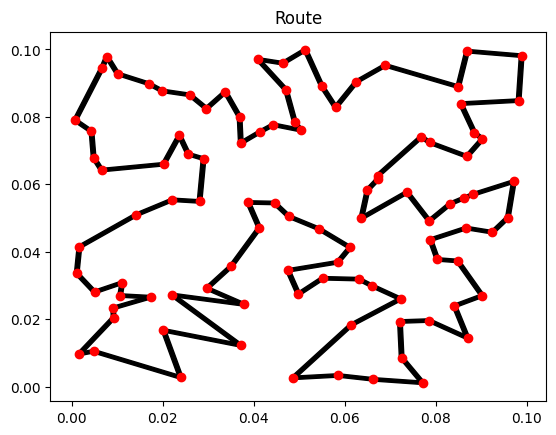

In [ ]:
num_city = 100
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(123)

####################上記を各自設定してください###################

# 乱数座標
coords = 0.1*torch.rand(num_city, 2, device=device)  # shape: (50, 2)

# 距離行列を計算（ユークリッド距離）
diffs = coords.unsqueeze(1) - coords.unsqueeze(0)  # shape: (50, 50, 2)
dists = torch.norm(diffs, dim=2)  # shape: (50, 50)

# TSPの定式化を呼び出し(coeffは制約係数: defaultは平均最大距離の1倍)
tsp_sample = gn.TSP(dists, coeff1=1, coeff2=1, device=device)

result, energy = op.auto_grid_amfd(tsp_sample.generator, [torch.Size([num_city-1, num_city-1])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)

x = result[0]

# 結果の確認
fig = tsp_sample.draw_route(x, coordinate=coords)
fig.show()


############# QUBO行列に一回変換して実行する場合 ###############

100%|██████████| 2401/2401 [00:00<00:00, 3185.77it/s]


Total Distance: tensor(0.5775, device='cuda:0')


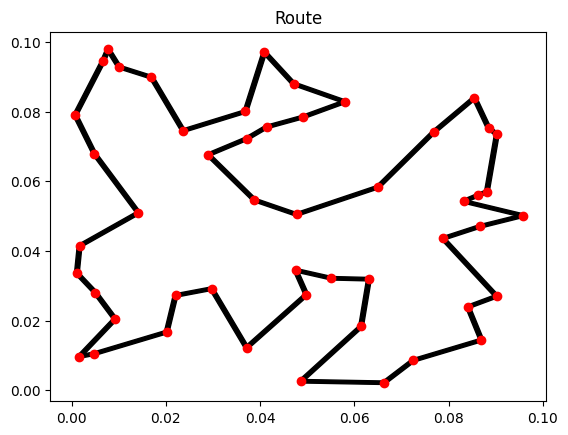

In [6]:
num_city = 50
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(123)

####################上記を各自設定してください###################

# 乱数座標
coords = 0.1*torch.rand(num_city, 2, device=device)  # shape: (50, 2)

# 距離行列を計算（ユークリッド距離）
diffs = coords.unsqueeze(1) - coords.unsqueeze(0)  # shape: (50, 50, 2)
dists = torch.norm(diffs, dim=2)  # shape: (50, 50)

# TSPの定式化を呼び出し(coeffは制約係数: defaultは平均最大距離の1倍)
tsp_sample = gn.TSP(dists, coeff1=1, coeff2=1, device=device)

# QUBOに変換
qubo, meta = md.get_qubo_save_memory(tsp_sample.generator, {'x':(num_city-1, num_city-1)}, device=dists.device)
const, h, Q = qubo['const'], qubo['h'], qubo['Q']


# 最適化の実行(各自パラメータを設定可能)
spin, energy = op.grid_amfd(const, h, Q, t_st=0.4, t_en=0.001, eta=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], zeta=[0, 1, 2, 5], Nstep=h.shape[0], rep_num=8)

# 複数GPUを使う場合
# spin, energy = op.amfd_multi_gpu(const, h, Q, t_st=0.4, t_en=0.001, eta=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], zeta=[0, 1, 2, 5], Nstep=h.shape[0], rep_num=8)

# 結果の確認
x = md.restore_variables(spin, meta['index_map'])['x']

fig = tsp_sample.draw_route(x, coordinate=coords)
fig.show()

####### 二次割当問題(QAP) デモ ##########

ランダムな二次元座標都市・ランダムな工場間流通量-->最適割当の提示

設定：
1. 都市の数: num_city
2. 実行デバイス: device
3. シード値: ランダム座標の乱数シード

100%|██████████| 20000/20000 [00:04<00:00, 4810.08it/s]


Score: tensor(17169.6230, device='cuda:0')


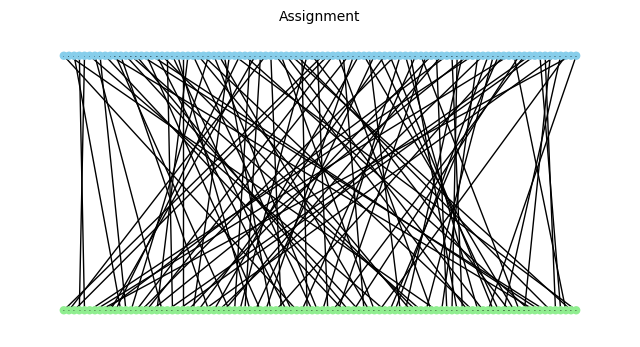

In [ ]:
num_city = 100
device = 'cuda:0'
# 乱数シードを固定
torch.manual_seed(123)

####################上記を各自設定してください###################

# 乱数座標
coords = torch.randn(num_city, 2, device=device) 

# 距離行列を計算（ユークリッド距離）
diffs = coords.unsqueeze(1) - coords.unsqueeze(0)  
dists = torch.norm(diffs, dim=2)  # shape: (50, 50)

# ランダム流通量
f = torch.rand(num_city, num_city, device=device)
f = f.T + f  # 対称行列化

# QAPの定式化を呼び出し(coeffは制約係数)
qap_sample = gn.QAP(d=dists, f=f, coeff1=1, coeff2=1, device=device)


# 実行
result, energy = op.auto_grid_amfd(qap_sample.generator, [torch.Size([num_city, num_city])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=1, Nstep=None, device=device)
x = result[0]
fig = qap_sample.draw_graph(x=x)
fig.show()
print('Score:', energy)


########  グラフ彩色問題(GCP)デモ  #########

ランダムな結合グラフ-->結合されているノードには同じ色が塗れない制約のもとで色数を最小化

設定：
1. ノードの数: num_node
2. 実行デバイス: device
3. シード値: ランダム座標の乱数シード
4. ランダム結合のスパーシティ: sparsity

Direct computing Hessian was failed: CUDA out of memory. Tried to allocate 5.24 GiB. GPU 0 has a total capacity of 23.53 GiB of which 3.27 GiB is free. Including non-PyTorch memory, this process has 20.24 GiB memory in use. Of the allocated memory 19.94 GiB is allocated by PyTorch, and 48.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables). Computing row-wise.


100%|██████████| 75150/75150 [00:30<00:00, 2433.42it/s]


色数： 19
制約充足： True


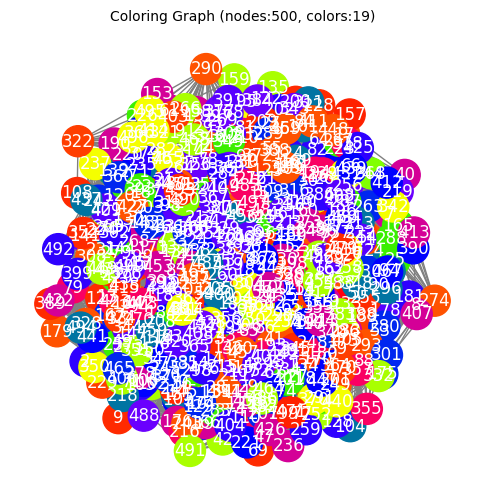

In [10]:
num_node = 500
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(0)
sparsity = 0.9

####################上記を各自設定してください###################

# ランダムグラフの作成
E = generate_random_graph(N=num_node, sparsity=sparsity, device=device)


# GCPの定式化を呼び出し(coeffは制約係数)
gcp_sample = gn.GCP(E=E, coeff1=1, coeff2=1, coeff3=1, num_color=None, device=device)

# 実行
result, energy = op.auto_grid_amfd(gcp_sample.generator, [torch.Size([num_node, gcp_sample.num_color]), torch.Size([gcp_sample.num_color])], zeta_vals=[0, 1, 2, 5, 10, 20, 50], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2], t_st=0.35, t_en=0.001, num_rep=1, Nstep=None, device=device)
x = result[0]
fig = gcp_sample.draw_coloring(x=x)
fig.show()
print('色数：', int(energy))
print('制約充足：', bool(torch.all(x.sum(dim=1)==1) and (torch.sum(torch.einsum('ij,ik,jk->', E.float().cpu(), x.cpu(), x.cpu()))==0)))

########  最大独立集合問題(MISP)デモ  #########

ランダムな結合グラフ-->結合されているノードには同じ色が塗れない制約のもとで色数を最小化

設定：
1. ノードの数: num_node
2. 実行デバイス: device
3. シード値: ランダム座標の乱数シード
4. ランダム結合のスパーシティ: sparsity

100%|██████████| 2000/2000 [00:02<00:00, 829.15it/s]


独立集合の大きさ： 314
制約充足： True


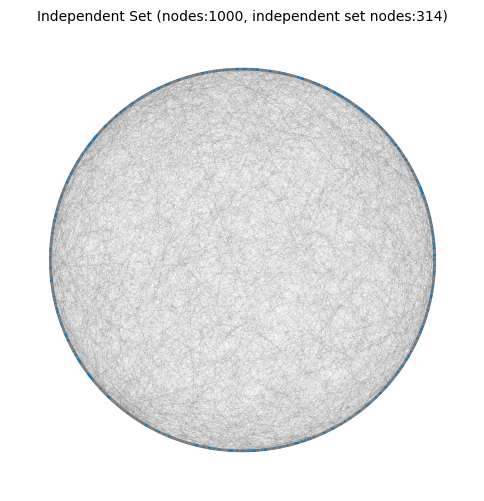

In [17]:
num_node = 1000
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(325)
sparsity = 0.99

####################上記を各自設定してください###################

# ランダムグラフの作成(対称行列)
E = generate_random_graph(N=num_node, sparsity=sparsity, device=device)


# MISPの定式化を呼び出し(coeffは制約係数)
misp_sample = gn.MISP(E=E, coeff1=1)


######## 自動微分を用いたQUBO変換なしでの実行 ##########

result, energy = op.auto_grid_amfd(misp_sample.generator, [torch.Size([num_node])], zeta_vals=[0, 1, 2, 5, 10, 20, 50], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2], t_st=0.35, t_en=0.001, num_rep=1, Nstep=None, device=device)
x = result[0]
fig = misp_sample.draw_independent_set(x=x)
fig.show()
print('独立集合の大きさ：', int(x.sum()))
print('制約充足：', bool((x.cpu()@E.float().cpu()*x.cpu()).sum()==0))

##### ビンパッキング問題(BPP)デモ ###

容量制約のもと、使うビンを最小化するような詰め方

設定：
1. アイテムの数: num_items
2. 実行デバイス: device
3. シード値: 乱数シード
4. capacity: 容量制約(1以上, 0.5*num_items未満が問題として妥当)   ※: 1未満にしたら物理的に入らない物が出てくる, 大きすぎると必ず入ってしまう

100%|██████████| 10682/10682 [00:05<00:00, 1990.95it/s]


ビンの使用数： 28
アイテムは1つのビンに入っている： True
容量制約： True 最大容量:1.83


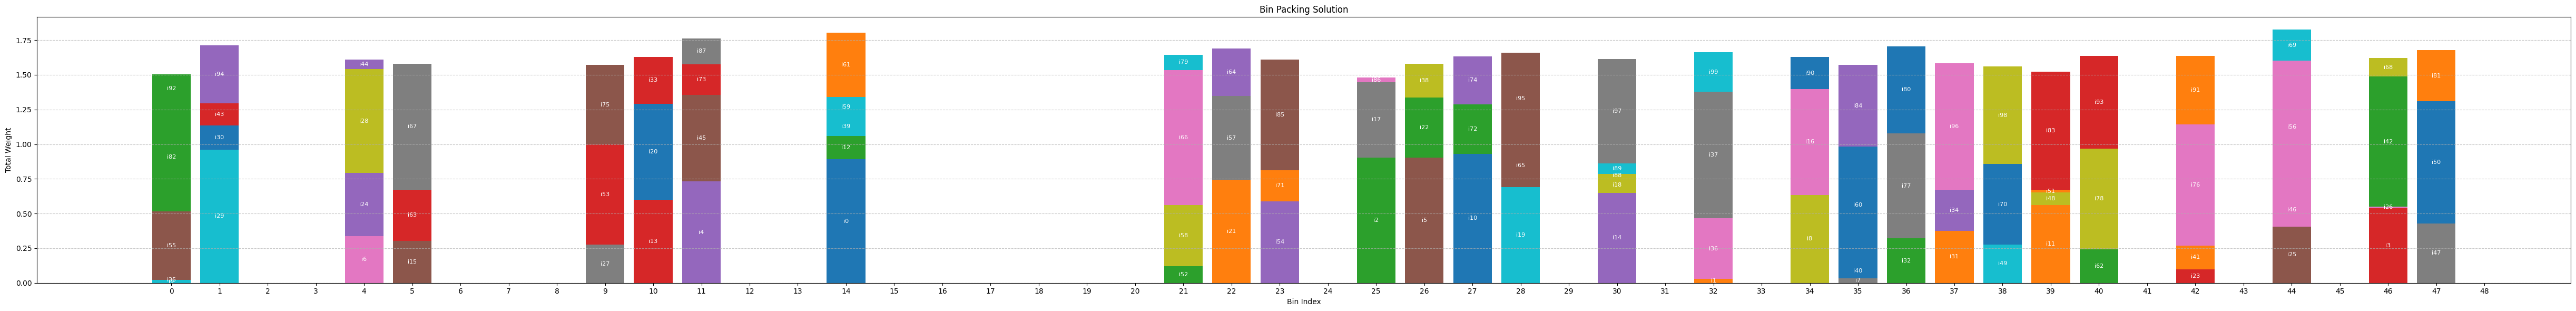

In [23]:
num_items = 100
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)
capacity = 2

####################上記を各自設定してください###################

# ランダム重量の作成
weight = torch.rand(num_items, device=device)


# BPPの定式化を呼び出し(coeffは制約係数)
bpp_sample = gn.BPP(weight=weight, capacity=capacity, num_bins=None, bit_size=8, coeff1=1, coeff2=1, coeff3=1)

# 実行
result, energy = op.auto_grid_amfd(bpp_sample.generator, [torch.Size([num_items, bpp_sample.num_bins]), torch.Size([bpp_sample.num_bins]), torch.Size([bpp_sample.num_bins, bpp_sample.bit_size])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)
x, y = result[0].to(device), result[1].to(device)
print('ビンの使用数：', torch.nonzero(x.sum(dim=0)).shape[0])
print('アイテムは1つのビンに入っている：', bool(((1 - x.sum(dim=1)) ** 2).sum()==0))
print('容量制約：', bool(torch.all((x * weight.view(-1, 1)).sum(dim=0)<=capacity)), '最大容量:{:.2f}'.format((x * weight.view(-1, 1)).sum(dim=0).max().item()))

fig = bpp_sample.draw_bin_packing_solution(x)
fig.show()

########## 二次ナップサック問題 ##############

容量制約のもと、価値(相互作用価値も含む)の最大化

設定：
1. アイテムの数: num_items
2. 実行デバイス: device
3. シード値: 乱数シード
4. capacity: 容量制約(1以上, 0.5*num_items未満が問題として妥当)   ※: 1未満にしたら物理的に入らない物が出てくる, 大きすぎると必ず入ってしまう


In [26]:
num_items = 2000
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)
capacity = 200

####################上記を各自設定してください###################

# ランダム重量の作成
weight = torch.rand(num_items, device=device)
value = torch.rand(num_items, device=device)
s = torch.rand(num_items, num_items, device=device)
co_value = (s + s.T) * generate_random_graph(num_items, sparsity=0.6, device=device)


# QKPの定式化を呼び出し(coeffは制約係数)
qkp_sample = gn.QKP(weight=weight, value=value, co_value=co_value, capacity=capacity, bit_size=8, coeff1=1)


result, energy = op.auto_grid_amfd(qkp_sample.generator, [torch.Size([num_items, ]), torch.Size([qkp_sample.bit_size])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)

# 結果の確認
x, y = result[0].to(device), result[1].to(device)
print('合計価値：{:.2f}'.format(((value*x).sum() + 0.5*((x@co_value)*x).sum()).item()))
print('容量制約：', bool(torch.all((x * weight).sum()<=capacity)), '\n容量:{:.2f}'.format((x * weight).sum().item()))


100%|██████████| 4016/4016 [00:01<00:00, 2121.68it/s]

合計価値：77312.55
容量制約： True 
容量:190.59


##################### シフトスケジューリング問題 ##########################

人件費の最小化 (1つのジョブに対して1人の作業員が割り当てられる)

設定：
1. ジョブの数: num_jobs
2. 人数: num_workers
3. 実行デバイス: device
4. シード値: 乱数シード

ランダムで自動生成
1. ジョブの開始時間と終了時間 (辞書型のリスト: [{"job":i, "start":t1, "end":t2},...]) ランダムに設定
2. 人件コスト: 全ての人1に設定 (default)
3. 実行可能ジョブ: J[i,j]: ワーカーiがジョブjを実行可能であれば1, 実行不可能であれば0となるグラフ (defaultはランダムに設定)

  0%|          | 0/2040 [00:00<?, ?it/s]

100%|██████████| 2040/2040 [00:01<00:00, 1134.12it/s]
/work2/k-kuroki/qubo_machine/generator.py:708: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle(


合計人件コスト：17.00
同時実行不可制約：0
ジョブは１人に割り当てられている:0


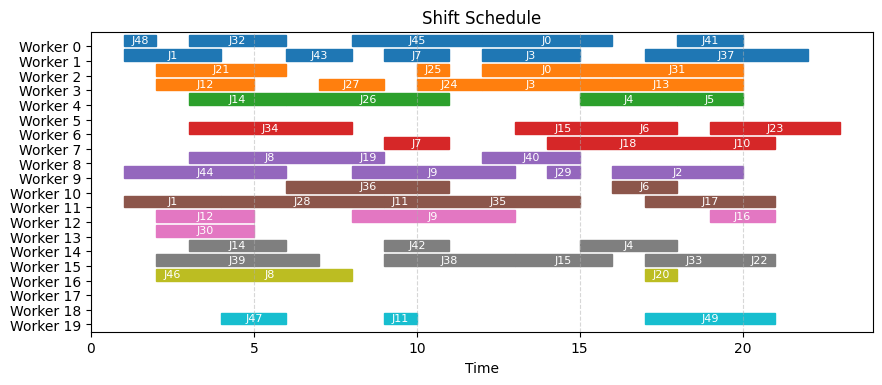

In [ ]:
num_jobs = 50
num_workers = 20 # ジョブ数以下に設定してください
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)

####################上記を各自設定してください###################

def create_jobs(num_jobs, min_duration=1, max_duration=5, max_start=20, seed=0):
    random.seed(seed)
    jobs = []
    for i in range(num_jobs):
        start = random.randint(0, max_start)
        duration = random.randint(min_duration, max_duration)
        end = start + duration
        jobs.append({"job": i, "start": start, "end": end})
    return jobs

# ランダム重量の作成
jobs = create_jobs(num_jobs=num_jobs)
cost = torch.ones(num_workers, device=device)
feasible_job = generate_random_graph(num_jobs, sparsity=0.0, device=device)[:num_workers]


# SSPの定式化を呼び出し(coeffは制約係数)
ssp_sample = gn.SSP(cost=cost, feasible_job=feasible_job, job_time=jobs, coeff1=1, coeff2=1, coeff3=1)


# 最適化の実行(各自パラメータを設定可能)
result, energy = op.auto_grid_amfd(ssp_sample.generator, [torch.Size([num_workers, num_jobs]), torch.Size([num_workers])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)

# 結果の確認

x, y = result[0].to(device), result[1].to(device)
print('合計人件コスト：{:.2f}'.format((cost * y).sum().item()))
print('同時実行不可制約：{:.0f}'.format(torch.einsum('ij,jk,ik->', x, ssp_sample.G, x)))
print('ジョブは１人に割り当てられている:{:.0f}'.format( ((1-torch.sum(x * ssp_sample.feasible_job, dim=0))**2).sum().item()))

fig = ssp_sample.draw_shift_schedule(x=x)
fig.show()

############## ジョブショップスケジューリング問題 (JSP) ##############

変数数: 1046
making hessian serially due to : CUDA out of memory. Tried to allocate 31.17 GiB. GPU 0 has a total capacity of 23.53 GiB of which 21.91 GiB is free. Process 359484 has 446.00 MiB memory in use. Including non-PyTorch memory, this process has 1.16 GiB memory in use. Of the allocated memory 702.62 MiB is allocated by PyTorch, with 258.00 MiB allocated in private pools (e.g., CUDA Graphs), and 223.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 2092/2092 [00:00<00:00, 7592.15it/s]


終了時間: 82.0


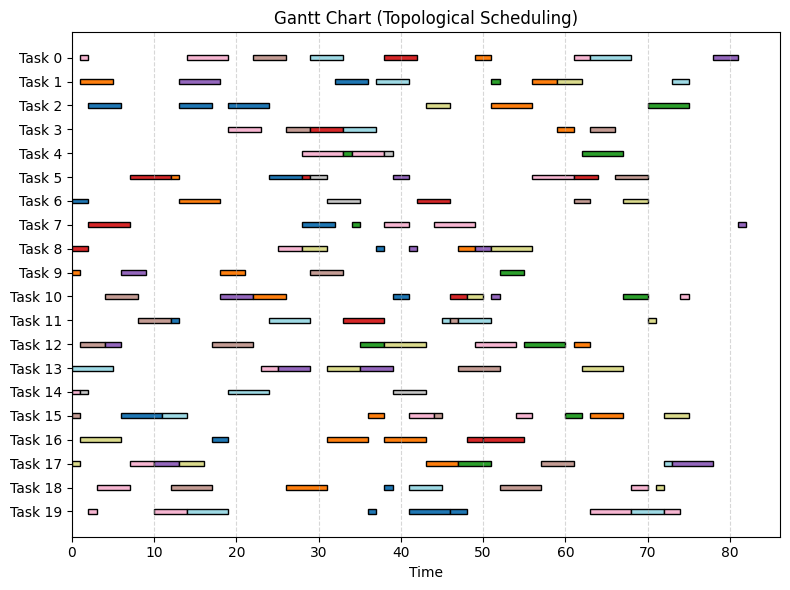

In [9]:
num_jobs_per_task = 10
num_tasks = 20
num_machines = 10
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)

####################上記を各自設定してください###################


def generate_random_jsp_instance(num_tasks, num_jobs, num_machines, max_time=10, sparsity=0.0, seed=None, device='cuda'):
    """
    ランダムなジョブショップスケジューリングインスタンスを生成する。

    Args:
        num_jobs (int): ジョブ数 N
        num_machines (int): マシン数 M
        max_time (int): 各マシン処理時間の最大値
        sparsity (float): 各ジョブがマシンを使わない確率 (0.0〜1.0)
        seed (int, optional): 乱数シード

    Returns:
        T: [N, M] 所要時間テンソル (torch.Tensor, dtype=torch.float)
        machine_order: List[List[int]] 各ジョブが使うマシンの順序（0始まり）
    """
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)

    N = num_tasks
    M = num_jobs

    # ランダム時間行列 T: [N, M]
    T = torch.randint(1, max_time + 1, (N, M)).float()

    # sparsity に基づいて一部をゼロにする
    mask = torch.rand(N, M) > sparsity
    T *= mask.float()
    sorted_T = []
    for row in T:
        nonzeros = row[row != 0]
        zeros = torch.zeros(len(row) - len(nonzeros), dtype=row.dtype)
        new_row = torch.cat([nonzeros, zeros])
        sorted_T.append(new_row)
    T = torch.stack(sorted_T)

    # 各ジョブのマシン使用順序をランダムに生成（所要時間 > 0 のマシンのみ）
    if seed is not None:
        torch.manual_seed(seed)

    # 同じサイズのテンソルを作り、初期値を -1 に
    machine_assignment = torch.full_like(T, fill_value=-1)

    # マスクを使ってゼロでない要素のインデックスを取得
    nonzero_mask = T != 0

    # ゼロでない要素の数
    num_nonzero = nonzero_mask.sum()

    # ランダムにマシンインデックスを割り当て
    random_indices = torch.randint(0, num_machines, (num_nonzero,), dtype=T.dtype)

    # マスクを使って値を代入
    machine_assignment[nonzero_mask] = random_indices

    return T.to(device), machine_assignment.to(device)



use_time, use_machine = generate_random_jsp_instance(num_tasks, num_jobs_per_task, num_machines, max_time=5, sparsity=0.3, device=device)

# JSPの定式化を呼び出し(coeffは制約係数)
jsp_sample = gn.JSP(use_time=use_time, use_machine=use_machine, transitive=False, coeff1=0.5, coeff2=0.5)

# QUBOに変換
print('変数数:',jsp_sample.num_x_symmetric_variables)

qubo, meta = md.get_qubo_save_memory(jsp_sample.approx_generator_symmetric, {'x':(jsp_sample.num_x_symmetric_variables,)}) # 有向グラフをx[j,i]=1-x[i,j]で定義した方法
const, h, Q = qubo['const'], qubo['h'], qubo['Q']

# 最適化の実行(各自パラメータを設定可能)
spin, energy = op.grid_amfd(const, h, Q, t_st=0.4, t_en=0.001, eta=[0.005, 0.01, 0.02, 0.05, 0.1, 0.2], zeta=[0, 1, 2, 5, 10, 20, 50], Nstep=None, rep_num=8, device=device)
result = md.restore_variables(spin, meta['index_map'])
x = result['x'].to(device)

# 直接最適化を行う場合
# result, energy = op.auto_grid_amfd(jsp_sample.approx_generator_symmetric, [torch.Size([jsp_sample.num_x_symmetric_variables, ])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)
# result, energy = op.auto_amfd(jsp_sample.approx_generator_symmetric, [torch.Size([jsp_sample.num_x_symmetric_variables, ])], zeta=0, eta=0.01, t_st=0.35, t_en=0.001, Nstep=None, device=device)
# x = result[0].to(device)

# 結果の確認
fig = jsp_sample.draw_job_schedule_symmetric(x)
fig.show()
print('終了時間:', jsp_sample.compute_makespan_symmetric(x))

############### 数分割問題 #######################

グループの合計値の均等化 

設定：
1. 要素数: num_elements
2. 実行デバイス: device
3. シード値: 乱数シード


100%|██████████| 2000/2000 [00:01<00:00, 1357.46it/s]


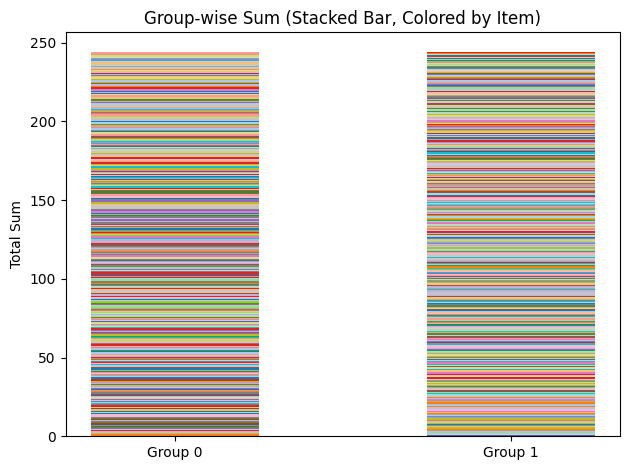

In [ ]:
num_elements = 1000
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)

#####################上記を各自設定してください###################

number_set = torch.rand(num_elements, device=device) 

# NPPの定式化を呼び出し(coeffは制約係数)
npp_sample = gn.NPP(number_set=number_set)


# 最適化の実行(各自パラメータを設定可能)

result, energy = op.auto_grid_amfd(npp_sample.generator, [torch.Size([num_elements, ])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)

# 結果の確認

x = result[0].to(device)

fig = npp_sample.draw_stack(x)
fig.show()

############### グラフ等分割問題 #######################

均等な頂点数を持つ複数のグループに分け、異なるグループ間のエッジ数を最小化

設定：
1. ノード数: num_nodes
2. グループ数: num_groups
3. 実行デバイス: device
4. シード値: 乱数シード

100%|██████████| 2000/2000 [00:03<00:00, 655.62it/s]

カット数: tensor(152.3521, device='cuda:0')


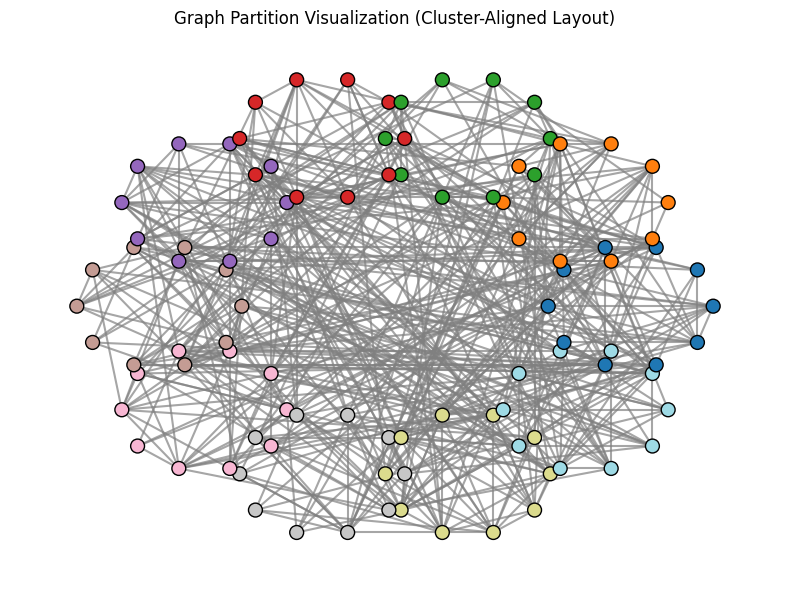

In [ ]:
num_nodes = 100
num_groups = 10
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)
torch.cuda.empty_cache()

#####################上記を各自設定してください###################


graph = generate_random_graph(N=num_nodes, sparsity=0.9, device=device)
graph = graph.float()*torch.rand((num_nodes, num_nodes), device=device)

# GPPの定式化を呼び出し(coeffは制約係数)
gpp_sample = gn.GPP(graph=graph, num_groups=num_groups, coeff1=1, coeff2=1)

# QUBOに変換
qubo, meta = md.get_qubo(gpp_sample.generator, {'x':(num_nodes, num_groups)}, device=device)
const, h, Q = qubo['const'], qubo['h'], qubo['Q']

# 最適化の実行(各自パラメータを設定可能)
result, energy = op.auto_grid_amfd(gpp_sample.generator, [torch.Size([num_nodes, num_groups])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.35, t_en=0.001, num_rep=4, Nstep=None, device=device)

# 結果の確認

x = result[0].to(device)
print('カット数:', energy)
fig = gpp_sample.draw_graph_partition(x)
fig.show()

############### 最大カット問題 #######################

グラフを二分割するときのカット数の最大化

設定：
1. ノード数: num_nodes
2. 実行デバイス: device
3. シード値: 乱数シード

In [9]:
num_nodes = 3000
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(18)
torch.cuda.empty_cache()

#####################上記を各自設定してください###################


graph = generate_random_graph(N=num_nodes, sparsity=0.5, device=device)
graph = graph.float()#*(torch.rand((num_nodes, num_nodes), device=device)-0.5)

# MCPの定式化を呼び出し(coeffは制約係数)
mcp_sample = gn.MCP(graph=graph)


# 最適化の実行(各自パラメータを設定可能)
result, energy = op.auto_grid_amfd(mcp_sample.generator, [torch.Size([num_nodes, ])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.4, t_en=0.001, num_rep=1, Nstep=None, device=device)

# 結果の確認
x = result[0].to(device)

print('カット数:', -energy.item())

100%|██████████| 6000/6000 [00:02<00:00, 2145.14it/s]

カット数: 1155910.0


############### 頂点被覆問題 #######################

全てのエッジのいずれかの端点を被覆するのに必要な頂点数の最小化

設定：
1. ノード数: num_nodes
2. 実行デバイス: device
3. シード値: 乱数シード

100%|██████████| 2000/2000 [00:01<00:00, 1014.75it/s]


頂点数: 683.0


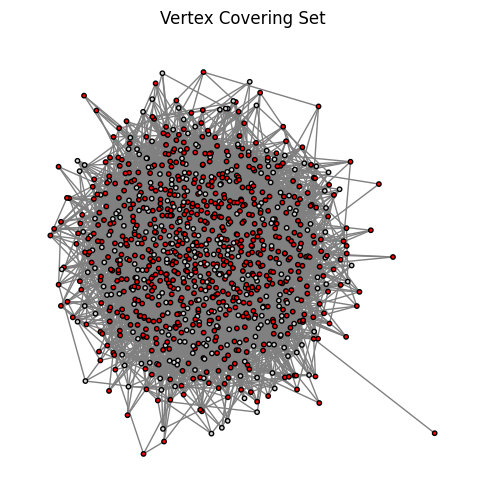

In [ ]:
num_nodes = 1000
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)
torch.cuda.empty_cache()

#####################上記を各自設定してください###################

graph = generate_random_graph(N=num_nodes, sparsity=0.99, device=device)

# VCPの定式化を呼び出し(coeffは制約係数)
vcp_sample = gn.VCP(graph=graph, coeff1=1)

# 最適化の実行(各自パラメータを設定可能)
result, energy = op.auto_grid_amfd(vcp_sample.generator, [torch.Size([num_nodes, ])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.4, t_en=0.001, num_rep=1, Nstep=None, device=device)

# 結果の確認
x = result[0].to(device)
print('頂点数:', energy.item())

fig = vcp_sample.draw_graph(x=x)
fig.show()

############### グラフ同型性問題 #######################

グループの合計値の均等化 

設定：
1. ノード数: num_nodes
2. 実行デバイス: device
3. シード値: 乱数シード

In [6]:
num_nodes = 100
device = 'cuda:0'
# 乱数シードを固定（再現性のため）
torch.manual_seed(1)
torch.cuda.empty_cache()

#####################上記を各自設定してください###################


graph = generate_random_graph(N=num_nodes, sparsity=0.5, device=device)

# GIPの定式化を呼び出し(coeffは制約係数)
gip_sample = gn.GIP(graph1=graph, graph2=graph, coeff1=1, coeff2=1)

# QUBOに変換
qubo, meta = md.get_qubo_save_memory(gip_sample.generator, {'x':(num_nodes, num_nodes)}, device=device)
const, h, Q = qubo['const'], qubo['h'], qubo['Q']

# 最適化の実行(各自パラメータを設定可能)
spin, energy = op.grid_amfd(const, h, Q, t_st=0.4, t_en=0.001, eta=[0.005, 0.01, 0.02, 0.05, 0.1, 0.2], zeta=[0, 1, 2, 5, 10, 20, 50], Nstep=None, rep_num=8, device=device)
result = md.restore_variables(spin, meta['index_map'])
x = result['x']

# result, energy = op.auto_grid_amfd(gip_sample.generator2, [torch.Size([num_nodes, num_nodes])], zeta_vals=[0, 1, 2, 5], eta_vals=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], t_st=0.4, t_en=0.001, num_rep=1, Nstep=None, device=device)
# x = result[0].to(device)

# 結果の確認
print('類似度(0に近いほど類似度が高い):', energy.item())


making hessian serially due to : CUDA out of memory. Tried to allocate 3725.29 GiB. GPU 0 has a total capacity of 23.53 GiB of which 20.74 GiB is free. Process 359484 has 446.00 MiB memory in use. Including non-PyTorch memory, this process has 2.33 GiB memory in use. Of the allocated memory 1.70 GiB is allocated by PyTorch, with 2.00 MiB allocated in private pools (e.g., CUDA Graphs), and 393.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 20000/20000 [00:31<00:00, 627.56it/s]


類似度(0に近いほど類似度が高い): 0.0
